# Redes neuronales en PyTorch

El aprendizaje automático clásico se basa en el uso de estadísticas para determinar las relaciones entre características y etiquetas, y puede ser muy eficaz para modelos predictivos. Sin embargo, el crecimiento masivo de la disponibilidad de datos, unido a los avances en la tecnología necesarios para procesarlos, ha propiciado la aparición de nuevas técnicas de aprendizaje automático que imitan la forma en que el cerebro procesa la información en una estructura denominada red neuronal artificial

PyTorch es un marco para crear modelos de aprendizaje automático, incuidas las redes neuronales profundas (DNNs). En este notebook, utilizaremos PyTorch para crear una red neuronal simple que clasifique a los pingüinos en especies basándose en la longitud y profundidad de su culmen (pico), la longitud de sus aletas y su masa corporal

## Explorando el Dataset

Antes de empezar a utilizar PyTorch para crear el modelo, vamos a cargar los datos que necesitamos del dataset de pingüinos de las Islas Palmer, que contiene observaciones de tres especies diferentes de pingüinos.


In [ ]:
import pandas as pd

# cargar el conjunto de datos de entrenamiento (excluyendo las filas con valores nulos)
#heart = pd.read_csv(r'heart_failure_clinical_records_dataset.csv').dropna()
heart = pd.read_csv(r'https://raw.githubusercontent.com/HLoM3/HeartFailure_Dataset/main/heart_failure_clinical_records_dataset.csv').dropna()
heart_copy = heart.copy(deep=True)
heart

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


(array([203.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  96.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

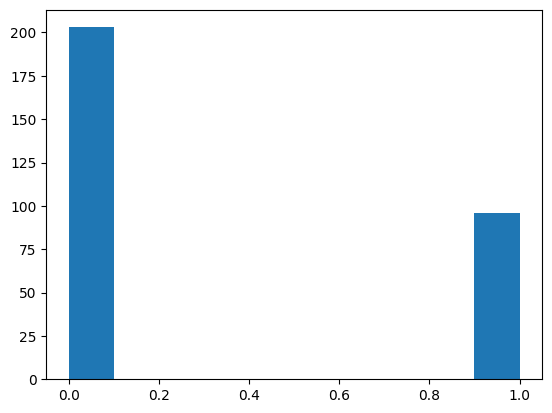

In [ ]:
import matplotlib.pyplot as plt

plt.hist(heart['DEATH_EVENT'])

Los modeos de *deep learning* funcionan mejor cuando las características están en escalas similares.

En una solución real, implementaríamos alguna normalización para cada característica, pero para mantener las cosas simples, solo cambiaremos la escala de FlipperLength y BodyMass para que estén en una escala similar a las medidas de la factura

In [ ]:
# El conjunto de datos es demasiado pequeño para ser útil para el aprendizaje profundo
# Así que vamos a sobremuestrearlo para aumentar su tamaño
heart = pd.concat([heart] * 3, ignore_index=True)


X = heart.drop(columns='DEATH_EVENT')
y = heart['DEATH_EVENT']

In [ ]:
import seaborn as sns

#sns.pairplot(heart)

In [ ]:
for columna in X.columns:
    # Obtener la media y la desviación estándar de la columna actual
    media = X[columna].mean()
    desviacion_estandar = X[columna].std()

    # Escalar la columna (restar la media y dividir por la desviación estándar)
    X[columna] = (X[columna] - media) / desviacion_estandar

Como es habitual en un problema de aprendizaje supervisado, dividiremos el conjunto de datos en un conjunto de registros con los que entrenaremos el modelo y un conjunto más pequeño con el que validaremos el modelo entrenado

In [ ]:
from sklearn.model_selection import train_test_split as tts

features = X.columns

print(f'Original length: {len(X)}')
# Dividimos los datos 80%-20% en los conjuntos de entrenamiento y prueba
X_temp, X_val, y_temp, y_val = tts(X.values, y.values, test_size=0.20, random_state=123, stratify=y.values)

X_train, X_test, y_train, y_test = tts(X_temp, y_temp,test_size=0.2, random_state=321, stratify=y_temp)

print(f'Len training: {len(X_train)}, len test: {len(X_test)}, len val: {len(X_val)}')

Original length: 897
Len training: 573, len test: 144, len val: 180


Las *características* son las medidas de cada observación de pingüino, y la *etiqueta* es un valor numérico que indica la especie de pingüino que representa la observación (Amelie, Papúa o Barbijo).

# Instalar e importar las bibliotecas PyTorch

Dado que planeamos utilizar PyTorch para crear nuestro clasificador de pingüinos, necesitaremos ejecutar las dos celdas siguientes para instalar e importar las bibliotecas PyTorch que pretendemos utilizar. La instalación específica de PyTorch depende de tu sistema operativo y de si tu computadora dispone de unidades de procesamiento gráfico (GPU) que puedan utilizarse para el procesamiento de alto rendimiento a través de cuda. Encontrará instrucciones detalladas en https://pytorch.org/get-started/locally/.

In [ ]:
#!pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as td

# Set random seed for reproducability
torch.manual_seed(159487)

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 2.1.0+cu118


### Preparar los datos para PyTorch

PyTorch utiliza cargadores de datos para cargar los datos de entrenamiento y validación por lotes. Ya hemos cargado los datos en arrays numpy, pero necesitamos envolverlos en conjuntos de datos PyTorch (en los que los datos se convierten en objetos tensor PyTorch) y crear cargadores para leer lotes de esos conjuntos de datos.

In [ ]:
# Crear un conjunto de datos y un cargador para los datos de entrenamiento y etiquetas

# Pasamos los numpy arrays a tenspres
train_x = torch.Tensor(X_train).float()
train_y = torch.Tensor(y_train).long()

# Instanciamos un objeto Dataset y le incluimos los tensores con las características de entrenamiento y de prueba
train_ds = td.TensorDataset(train_x,train_y)

# Creamos un DataLoader para ir pasando el conjunto de entrenamiento por lotes al modelo, en este caso, la red neuronal
train_loader = td.DataLoader(train_ds, batch_size=20,
    shuffle=False, num_workers=1)

# Crear un conjunto de datos y un cargador para los datos de prueba y las etiquetas
test_x = torch.Tensor(X_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=20,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


# Definir una red neuronal

Ahora estamos listos para definir nuestra red neuronal. En este caso, vamos a crear una red que consta de 3 capas totalmente conectadas:

* Una capa de entrada que recibe un valor de entrada para cada característica (en este caso, las cuatro medidas de los pingüinos) y aplica una **función de activación ReLU**.

* Una capa oculta que recibe diez entradas y aplica una función de activación ReLU.

* Una capa de salida que utiliza una **función de activación Softmax** para generar una salida para cada especie de pingüino (que representan las probabilidades de clasificación para cada una de las tres posibles especies de pingüinos). Las funciones Softmax producen un vector con valores de probabilidad que suman 1.

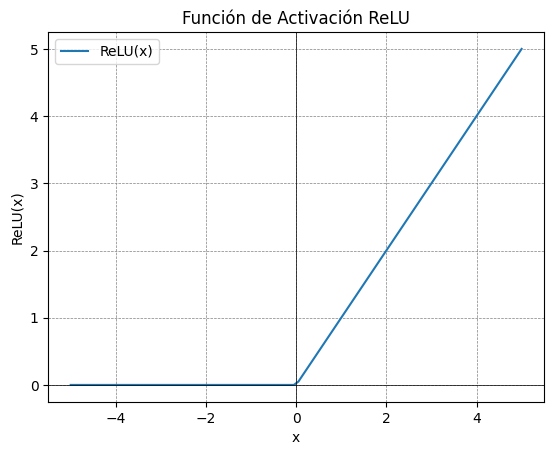

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Definir la función de activación ReLU
def relu(x):
    return np.maximum(0, x)

# Generar datos para graficar
x_values = np.linspace(-5, 5, 100)
y_values = relu(x_values)

# Crear la gráfica
plt.plot(x_values, y_values, label='ReLU(x)')
plt.title('Función de Activación ReLU')
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

In [ ]:
# Número de nodos en la capa oculta
hl = 15

# Definimos la red neuronal
class HeartNet(nn.Module):
    def __init__(self):

        super(HeartNet, self).__init__()
        self.fc1 = nn.Linear(len(features), hl)
        self.fc2 = nn.Linear(hl, hl)
        self.fc3 = nn.Linear(hl, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x),dim=1)
        return x

# Crear una instancia del modelo a partir de la red
model = HeartNet()
print(model)

HeartNet(
  (fc1): Linear(in_features=12, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=15, bias=True)
  (fc3): Linear(in_features=15, out_features=2, bias=True)
)


# Entrenar el modelo sin regulizar

Para entrenar el modelo, necesitamos alimentar repetidamente los valores de entrenamiento a través de la red, utilizar una función de pérdida (loss cost) para calcular la pérdida, utilizar un optimizador para retropropagar (backpropagation) los ajustes de peso y valor de sesgo, y validar el modelo utilizando los datos de prueba que retuvimos.

Para ello, vamos a crear una función para entrenar y optimizar el modelo, y una función para probar el modelo. A continuación, llamaremos a estas funciones de forma iterativa durante 50 épocas, el registro de la pérdida y las estadísticas de precisión para cada época.

In [ ]:
def train(model, data_loader, optimizer):
    # Poner el modelo en modo entrenamiento
    model.train() # afecta a ciertas capas como Dropout o BatchNorm que tienen comportamiento diferente durante el entrenamiento y la evaluación
    train_loss = 0

    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad() # Limpia los gradientes, porque en Pytorch se acumulan por defecto
        out = model(data) # Generamos las salidas del modelo
        loss = loss_criteria(out, target) # Calculo del error
        train_loss += loss.item()

        # retropropagar
        loss.backward() # Calculo de los gradientes respecto a cada parámetro
        optimizer.step() # Actualiza los pesos del modelo basado en los gradientes

    #Perdida media por retorno
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss


def test(model, data_loader):
    # Cambiar el modelo en modo evaluación (para no retropropagar)
    model.eval()
    test_loss = 0
    correct = 0

    # Desactivamos el calculo de gradientes
    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Obtener las predicciones
            out = model(data)

            # calcular la pérdida
            test_loss += loss_criteria(out, target).item()

            # Calcular el accuracy
            _, predicted = torch.max(out.data, 1) # Obtienen los indices de la clase predicha
            correct += torch.sum(target==predicted).item()

    # Calcular la pérdida media y precisión total de esta época
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

    # Pérdida media de retorno para la época
    return avg_loss

# Especificación de los criterios de pérdida (CrossEntropyLoss para la clasificación multiclase)
loss_criteria = nn.CrossEntropyLoss()

# Utilizar un optimizador "Adam" par ajustar los pesos
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Si se quisiera usar SGD con o sin momentum
# momentum = 0.9       # Un valor común para el momentum en SGD
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Se guardarán las métricas de cada época en estas matrices
epoch_nums = []
training_loss = []
validation_loss = []

# Variables para el early stopping
patience = 10  # Define cuántas épocas esperar sin mejora antes de detener el entrenamiento
best_loss = float('inf')
epochs_no_improve = 0
checkpoint_path = 'model_checkpoint.pth'  # Ruta del archivo para guardar el mejor modelo

# Entrenar más de 50 épocas
epochs = 100
for epoch in range(1, epochs + 1):

    print('Epoch: {}'.format(epoch))

    train_loss = train(model, train_loader, optimizer)
    test_loss = test(model, test_loader)

    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

    # Guardar el modelo si la pérdida de validación mejora
    if test_loss < best_loss:
        best_loss = test_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), checkpoint_path)
    else:
        epochs_no_improve += 1

    # Detener el entrenamiento si no hay mejoras durante un número determinado de épocas
    if epochs_no_improve == patience:
        print(f'Entrenamiento detenido después de {epoch} epochs!')
        break

# Crear una nueva clase de modelo y cargar los pesos
model = HeartNet()
model.load_state_dict(torch.load(checkpoint_path))

Epoch: 1
Training set: Average loss: 0.716689
Validation set: Average loss: 0.701181, Accuracy: 49/144 (34%)

Epoch: 2
Training set: Average loss: 0.690195
Validation set: Average loss: 0.679577, Accuracy: 103/144 (72%)

Epoch: 3
Training set: Average loss: 0.659614
Validation set: Average loss: 0.653697, Accuracy: 98/144 (68%)

Epoch: 4
Training set: Average loss: 0.625384
Validation set: Average loss: 0.629394, Accuracy: 98/144 (68%)

Epoch: 5
Training set: Average loss: 0.596142
Validation set: Average loss: 0.612805, Accuracy: 98/144 (68%)

Epoch: 6
Training set: Average loss: 0.574304
Validation set: Average loss: 0.599480, Accuracy: 99/144 (69%)

Epoch: 7
Training set: Average loss: 0.555297
Validation set: Average loss: 0.585953, Accuracy: 107/144 (74%)

Epoch: 8
Training set: Average loss: 0.536455
Validation set: Average loss: 0.571113, Accuracy: 109/144 (76%)

Epoch: 9
Training set: Average loss: 0.517006
Validation set: Average loss: 0.555885, Accuracy: 110/144 (76%)

Epoch:

<All keys matched successfully>

### Mientras se ejecuta el proceso de formación, entendamos que esta ocurriendo:

1. En cada época, el conjunto completo de datos de entrenamiento se transmite a través de la red. Hay cuatro características para cada observación y cuatro nodos correspondientes en la capa de entrada, por lo que las características de cada observación se transmiten como un vector de cuatro valores a esa capa. Sin embargo, por razones de eficacia, los vectores de características se agrupan en lotes, de modo que cada vez se introduce una matriz de múltiples vectores de características.

2. La matriz de valores de características es procesada por una función que realiza una *suma ponderada* utilizando pesos y *valores de sesgo* inicializados. El resultado de esta función es procesado por la **función de activación** de la capa de entrada para limitar los valores transmitidos a los nodos de la capa siguiente.

3. La *suma ponderada* y *las funciones de activación* se repiten en cada capa. Observe que las funciones operan sobre vectores y matrices en lugar de sobre valores escalares individuales. En otras palabras, el paso hacia delante es esencialmente una serie de funciones de álgebra lineal anidadas. Esta es la razón por la que los científicos de datos prefieren utilizar computadoras con unidades de procesamiento gráfico (GPU), ya que están optimizados para cálculos de matrices y vectores.

4. En la última capa de la red, los vectores de salida contienen un valor de probabilidad para cada clase posible (en este caso, las clases 0, 1 y 2). Este vector es procesado por una *función de pérdida* para determinar la distancia entre los valores calculados por la red y los valores reales. Supongamos, por ejemplo, que la observación de un pingüino papúa (clase 1) es \[0,3, 0,4, 0,3\]. La predicción correcta debería ser \[0,0, 1,0, 0,0\], por lo que la varianza entre los valores predichos y reales (lo lejos que está cada valor predicho de lo que debería ser) es \[0,3, 0,6, 0,3\]. Esta varianza se agrega para cada lote y se mantiene como un agregado en ejecución para calcular el nivel general de error (*pérdida*) incurrido por los datos de entrenamiento para la época.

5. Al final de cada época, los datos de validación se pasan por la red y también se calculan su *pérdida* y *precisión* (proporción de predicciones correctas basadas en el valor de probabilidad más alto del vector de salida). Es importante hacer esto porque nos permite comparar el rendimiento del modelo utilizando datos en los que no se ha entrenado, lo que nos ayuda a determinar si generalizará bien para los nuevos datos o si está *sobreajustado* a los datos de entrenamiento.

6. Una vez que todos los datos han pasado a través de la red, la salida de la función de pérdida para los datos de *entrenamiento* (pero <u>no</u> los datos de *validación*) se pasa al optimizador. Los detalles precisos de cómo el optimizador procesa la pérdida varían dependiendo del algoritmo de optimización específico que se utilice; pero fundamentalmente se puede pensar en toda la red, desde la capa de entrada hasta la función de pérdida como una gran función anidada (*compuesta*). El optimizador aplica algo de **cálculo diferencial** para calcular *derivadas parciales* de la función con respecto a cada peso y valor de sesgo que se utilizó en la red. Es posible hacer esto eficientemente para una función anidada debido a algo llamado *regla de la cadena*, que permite determinar la derivada de una función compuesta a partir de las derivadas de su función interna y funciones externas. No es necesario preocuparse por los detalles matemáticos (el optimizador lo hace por ti), pero el resultado final es que las derivadas parciales nos indican la pendiente (o *gradiente*) de la función de pérdida con respecto a cada valor de peso y sesgo; en otras palabras, podemos determinar si aumentar o disminuir los valores de peso y sesgo para reducir la pérdida.

7. Una vez determinada la dirección en la que deben ajustarse los pesos y los sesgos, el optimizador utiliza la *velocidad de aprendizaje* para determinar cuánto debe ajustarlos y, a continuación, trabaja hacia atrás a través de la red en un proceso denominado *backpropagation* para asignar nuevos valores a los pesos y sesgos de cada capa.

8. Ahora la siguiente época repite todo el proceso de entrenamiento, validación y retropropagación comenzando con los pesos y sesgos revisados de la época anterior, lo que esperamos que resulte en un menor nivel de pérdida.

9. El proceso continúa así durante 50 épocas.

### Revisar las pérdidas del entrenamiento y la validación

Una vez completado el entrenamiento, podemos examinar las métricas de pérdida que registramos durante el entrenamiento y la validación del modelo. Realmente estamos buscando dos cosas:

* La pérdida debe reducirse con cada epoch, mostrando que el modelo está aprendiendo los pesos y sesgos correctos para predecir las etiquetas correctas.
* La pérdida de entrenamiento y la pérdida de validación deberían seguir una tendencia similar, mostrando que el modelo no se está sobreajustando a los datos de entrenamiento.

Vamos a trazar las métricas de pérdida y ver:

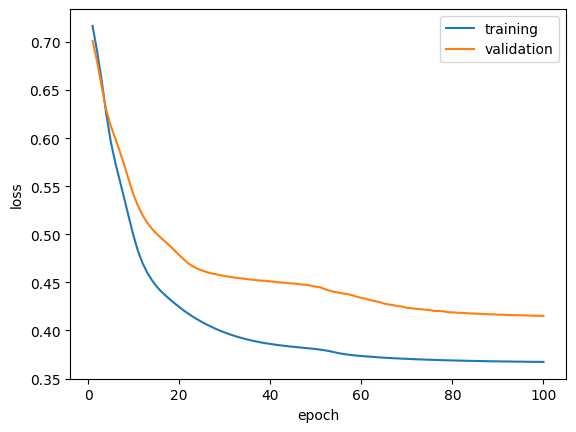

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Ver los pesos y sesgos aprendidos
El modelo entrenado consiste en los pesos y sesgos finales que fueron determinados por el optimizador durante el entrenamiento. Basándonos en nuestro modelo de red, deberíamos esperar los siguientes valores para cada capa:

* **Capa 1:** Hay cuatro valores de entrada que van a diez nodos de salida, por lo que debería haber 10 x 4 pesos y 10 valores de sesgo.
* **Capa 2:** Hay diez valores de entrada que van a diez nodos de salida, por lo que debería haber 10 x 10 pesos y 10 valores de sesgo.
* **Capa 3:** Hay diez valores de entrada que van a tres nodos de salida, por lo que debería haber 3 x 10 pesos y 3 valores de sesgo.

In [ ]:
for param_tensor in model.state_dict():
    print(param_tensor, "\n", model.state_dict()[param_tensor].numpy())

fc1.weight 
 [[-0.12272143  0.06595253  0.22632112 -0.03276735 -0.6088308   0.08836228
  -0.5645437   0.47112513 -0.24961698 -0.5726309   0.05350627  0.13673447]
 [ 0.06778631  0.2577106  -0.00234413  0.37186453  0.00098942  0.4078822
   0.18224455 -0.34619734 -0.23144877 -0.16705756 -0.28906313  0.42885575]
 [-0.0394498  -0.40243852  0.06272103 -0.3526995   0.43881977 -0.1463941
  -0.05737845 -0.89730364  0.4291269  -0.09044643  0.01106588  0.109772  ]
 [-0.20016919  0.2805364   0.09020041 -0.4324139   0.34805885  0.03298396
   0.16114172 -0.33096415  0.22513156  0.02465553 -0.3098526   0.1640802 ]
 [-0.18201202 -0.16713324  0.11254783 -0.20385925 -0.41176635  0.04244284
   0.46011823 -0.484323   -0.10308743 -0.07100409  0.2534854  -0.39324915]
 [ 0.6156489  -0.26431367  0.3659176   0.21583444  0.13880756 -0.04646144
   0.04058588  0.09624351  0.37546673 -0.04149314 -0.38246167 -0.48537493]
 [-0.04251797  0.04635374 -0.02167919  0.18149568  0.31459677  0.41864705
  -0.13904478 -0.2093

### Evaluar el rendimiento del modelo

¿Es bueno el modelo? La precisión bruta de los datos de validación parece indicar que predice bastante bien, pero suele ser útil profundizar un poco más y comparar las predicciones de cada clase posible. Una forma habitual de visualizar el rendimiento de un modelo de clasificación es crear una matriz de confusión que muestre una tabla cruzada de predicciones correctas e incorrectas para cada clase.

[[93  5]
 [11 35]]


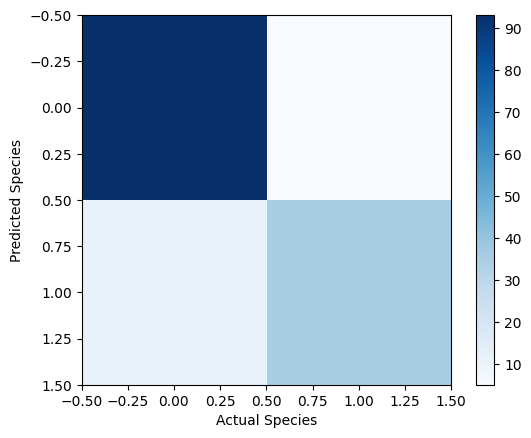

In [ ]:
#Pytorch no tiene una métrica de matriz de confusión incorporada, así que usaremos SciKit-Learn
from sklearn.metrics import confusion_matrix
import numpy as np

# Poner el modelo en modo evaluación
model.eval()

# Obtener predicciones para los datos de prueba
x = torch.Tensor(X_test).float()
_, predicted = torch.max(model(x).data, 1)

# Trazar la matriz de confusión
cm = confusion_matrix(y_test, predicted.numpy())
print(cm)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
#plt.xticks(tick_marks, 2, rotation=45)
#plt.yticks(tick_marks, 2)
plt.xlabel("Actual Species")
plt.ylabel("Predicted Species")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted.numpy()))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92        98
           1       0.88      0.76      0.81        46

    accuracy                           0.89       144
   macro avg       0.88      0.85      0.87       144
weighted avg       0.89      0.89      0.89       144



La matriz de confusión debe mostrar una línea diagonal fuerte que indique que hay más predicciones correctas que incorrectas para cada clase.

### Guardar el modelo entrenado

Ahora que tenemos un modelo que creemos razonablemente preciso, podemos guardar sus pesos entrenados para utilizarlos más adelante.

In [ ]:
# Guardar los pesos del modelo
#model_file = 'models/penguin_classifier.pt'
#torch.save(model.state_dict(), model_file)
#del model
#print('model saved as', model_file)

### Utilizar el modelo entrenado

Cuando tengamos una nueva observación de un pingüino, podemos utilizar el modelo para predecir la especie.

In [ ]:
#  Nuevas características del pingüino
x_new = [[75,1,600,1,20,1,210000,2,140,1,1,6]]
print ('New sample: {}'.format(x_new))

# Crear una nueva clase de modelo y cargar los pesos
model = HeartNet()
model.load_state_dict(torch.load(checkpoint_path))

# Poner el modelo en modo evaluación
model.eval()

# Obtener una predicción para la nueva muestra de datos
x = torch.Tensor(x_new).float()
_, predicted = torch.max(model(x).data, 1)

print('Prediction:',predicted.item())

New sample: [[75, 1, 600, 1, 20, 1, 210000, 2, 140, 1, 1, 6]]
Prediction: 0


In [ ]:
model = HeartNet()
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

model.eval()

# Convierte tu conjunto de validación a un tensor de PyTorch (si aún no lo está)
X_test_tensor = torch.Tensor(X_test).float()

# Realiza las predicciones
with torch.no_grad():
    # Obtén las probabilidades de salida (puedes ajustar esto según tu modelo)
    outputs = model(X_test_tensor)

# Convierte las probabilidades a etiquetas predichas
_, predicted_labels = torch.max(outputs, 1)

# Convierte las etiquetas predichas a una lista de Python
y_pred = predicted_labels.tolist()

De la clase sin evento cardiaco, hay 104.0 observaciones, equivale a 72.22222222222221 %
De la clase CON evento cardiaco, hay 40.0 observaciones, equivale a 27.77777777777778 %


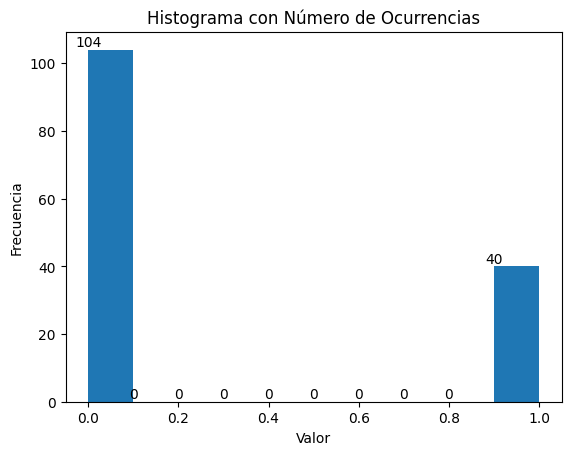

In [ ]:
plt.hist(y_pred, color='blue', alpha=0.7)

# Obtiene la frecuencia de ocurrencias en cada bin
counts, bins, _ = plt.hist(y_pred)

# Agrega el número de ocurrencias en cada bin como texto en el gráfico
for count, bin_value in zip(counts, bins):
    plt.text(bin_value, count, str(int(count)), ha='center', va='bottom')

# Configura etiquetas y título
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Histograma con Número de Ocurrencias')

sinE = counts[0]
conE = counts[-1]

print(f"De la clase sin evento cardiaco, hay {sinE} observaciones, equivale a {(sinE/len(X_test))*100} %")
print(f"De la clase CON evento cardiaco, hay {conE} observaciones, equivale a {(conE/len(X_test))*100} %")

[texto del vínculo](https://)#Red neuronal con regularización

$[(y- \hat{y})+(y-\hat{y})^2]⋅ \frac {33}{66}$

In [ ]:
# Pasamos los numpy arrays a tenspres
train_x = torch.Tensor(X_train).float()
train_y = torch.Tensor(y_train).long()

# Instanciamos un objeto Dataset y le incluimos los tensores con las características de entrenamiento y de prueba
train_ds = td.TensorDataset(train_x,train_y)

# Creamos un DataLoader para ir pasando el conjunto de entrenamiento por lotes al modelo, en este caso, la red neuronal
train_loader = td.DataLoader(train_ds, batch_size=2,
    shuffle=False, num_workers=1)

# Crear un conjunto de datos y un cargador para los datos de prueba y las etiquetas
test_x = torch.Tensor(X_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=2,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, C=0.01):
        super(CustomLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss()  # Ajusta la función de pérdida según tu tarea
        self.C = C

    def forward(self, output, target):
        elementwise_result = ((target - output) + (2*(target - output))**2)  * (32/68)
        aggregated_result = torch.sum(elementwise_result)

        primary_loss = self.criterion(output, target)

        # Combina la pérdida de la tarea principal y el término adicional
        loss = primary_loss + self.C * aggregated_result

        return loss

In [ ]:
def trainR(model, data_loader, optimizer):
    model.train()
    train_loss = 0
    custom_loss = CustomLoss(C=0.01)

    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        optimizer.zero_grad()
        out = model(data)

        loss = custom_loss(out, target)

        train_loss += loss.item()

        loss.backward() # Calculo de los gradientes respecto a cada parámetro
        optimizer.step() # Actualiza los pesos del modelo basado en los gradientes

    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss


def testR(model, data_loader):
    model.eval()
    test_loss = 0
    correct = 0
    custom_loss = CustomLoss(C=0.01)

    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Obtener las predicciones
            out = model(data)

            # calcular la pérdida
            loss = custom_loss(out,target)
            #loss = loss_criteria(out, target) + ((out-target)+(out-target)**2)*(33/66)
            test_loss += loss.item()

            _, predicted = torch.max(out.data, 1) # Obtienen los indices de la clase predicha
            correct += torch.sum(target==predicted).item()

    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

    return avg_loss

loss_criteria = nn.CrossEntropyLoss()

# Utilizar un optimizador "Adam" par ajustar los pesos
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Se guardarán las métricas de cada época en estas matrices
epoch_nums = []
training_loss = []
validation_loss = []

# Variables para el early stopping
patience = 10  # Define cuántas épocas esperar sin mejora antes de detener el entrenamiento
best_loss = float('inf')
epochs_no_improve = 0
checkpoint_path = 'model_checkpoint.pth'  # Ruta del archivo para guardar el mejor modelo

# Entrenar
epochs = 100
for epoch in range(1, epochs + 1):

    print('Epoch: {}'.format(epoch))

    train_loss = trainR(model, train_loader, optimizer)
    test_loss = testR(model, test_loader)

    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

    # Guardar el modelo si la pérdida de validación mejora
    if test_loss < best_loss:
        best_loss = test_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), checkpoint_path)
    else:
        epochs_no_improve += 1

    # Detener el entrenamiento si no hay mejoras durante un número determinado de épocas
    if epochs_no_improve == patience:
        print(f'Entrenamiento detenido después de {epoch} epochs!')
        break

model = HeartNet()
model.load_state_dict(torch.load(checkpoint_path))

Epoch: 1
Training set: Average loss: 0.403985
Validation set: Average loss: 0.461024, Accuracy: 128/144 (89%)

Epoch: 2
Training set: Average loss: 0.404509
Validation set: Average loss: 0.460012, Accuracy: 128/144 (89%)

Epoch: 3
Training set: Average loss: 0.403380
Validation set: Average loss: 0.459522, Accuracy: 128/144 (89%)

Epoch: 4
Training set: Average loss: 0.401330
Validation set: Average loss: 0.458865, Accuracy: 128/144 (89%)

Epoch: 5
Training set: Average loss: 0.401013
Validation set: Average loss: 0.458458, Accuracy: 128/144 (89%)

Epoch: 6
Training set: Average loss: 0.400866
Validation set: Average loss: 0.457913, Accuracy: 128/144 (89%)

Epoch: 7
Training set: Average loss: 0.400815
Validation set: Average loss: 0.457539, Accuracy: 128/144 (89%)

Epoch: 8
Training set: Average loss: 0.400799
Validation set: Average loss: 0.457084, Accuracy: 128/144 (89%)

Epoch: 9
Training set: Average loss: 0.400746
Validation set: Average loss: 0.456821, Accuracy: 128/144 (89%)

E

<All keys matched successfully>

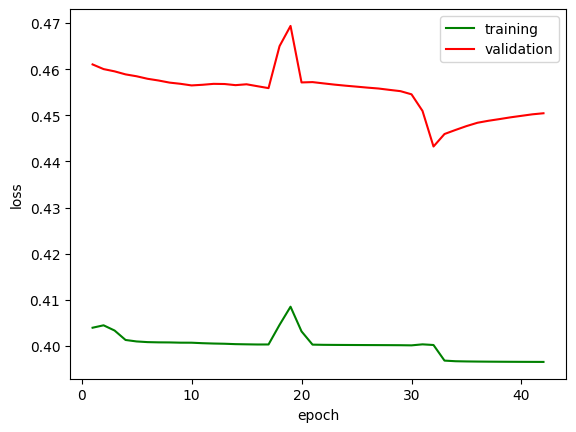

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss, color='green')
plt.plot(epoch_nums, validation_loss, color='red')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

[[94  4]
 [ 9 37]]


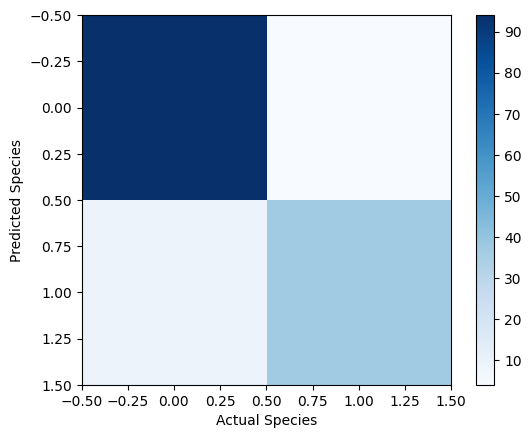

In [ ]:
#Pytorch no tiene una métrica de matriz de confusión incorporada, así que usaremos SciKit-Learn
from sklearn.metrics import confusion_matrix
import numpy as np

# Poner el modelo en modo evaluación
model.eval()

# Obtener predicciones para los datos de prueba
x = torch.Tensor(X_test).float()
_, predicted = torch.max(model(x).data, 1)

# Trazar la matriz de confusión
cm = confusion_matrix(y_test, predicted.numpy())
print(cm)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
#plt.xticks(tick_marks, 2, rotation=45)
#plt.yticks(tick_marks, 2)
plt.xlabel("Actual Species")
plt.ylabel("Predicted Species")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted.numpy()))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94        98
           1       0.90      0.80      0.85        46

    accuracy                           0.91       144
   macro avg       0.91      0.88      0.89       144
weighted avg       0.91      0.91      0.91       144



In [ ]:
model = HeartNet()
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

model.eval()

# Convierte tu conjunto de validación a un tensor de PyTorch (si aún no lo está)
X_test_tensor = torch.Tensor(X_test).float()

# Realiza las predicciones
with torch.no_grad():
    # Obtén las probabilidades de salida (puedes ajustar esto según tu modelo)
    outputs = model(X_test_tensor)

# Convierte las probabilidades a etiquetas predichas
_, predicted_labels = torch.max(outputs, 1)

# Convierte las etiquetas predichas a una lista de Python
y_pred = predicted_labels.tolist()

De la clase sin evento cardiaco, hay 103.0 observaciones, equivale a 71.52777777777779 %
De la clase CON evento cardiaco, hay 41.0 observaciones, equivale a 28.47222222222222 %


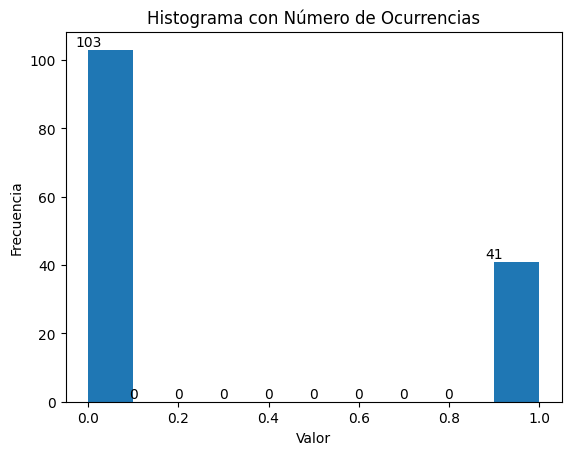

In [ ]:
plt.hist(y_pred, color='green', alpha=0.7)

# Obtiene la frecuencia de ocurrencias en cada bin
counts, bins, _ = plt.hist(y_pred)

# Agrega el número de ocurrencias en cada bin como texto en el gráfico
for count, bin_value in zip(counts, bins):
    plt.text(bin_value, count, str(int(count)), ha='center', va='bottom')

# Configura etiquetas y título
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Histograma con Número de Ocurrencias')

sinE = counts[0]
conE = counts[-1]

print(f"De la clase sin evento cardiaco, hay {sinE} observaciones, equivale a {(sinE/len(X_test))*100} %")
print(f"De la clase CON evento cardiaco, hay {conE} observaciones, equivale a {(conE/len(X_test))*100} %")